In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (6,5)
AGENTS = ["B1","B2","B3","B4",
          "C1","C2","C3","C4",
          "D1","D2","D3","D4",
          "E1","E2","E3","E4"]   # any 16-agent ordering you used


In [40]:
path = "ckpt/block_normal/Ours_Attention/42_attn_per_episode.npy"
A = np.load(path)           # shape (E,16,16)
print(f"Loaded {A.shape[0]} episodes   matrix size {A.shape[1:]}")
# quick sanity-check: rows sum to 1 ?
print( np.round(A[0].sum(-1), 3) )     # should all be 1.000

Loaded 80 episodes   matrix size (16, 16)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


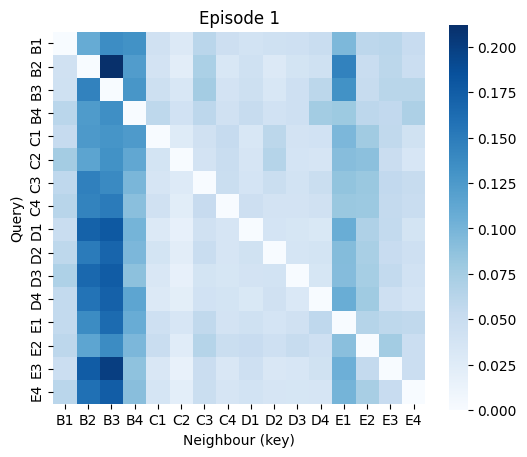

In [41]:
def show_heat(ep=0, cmap="Blues"):
    sns.heatmap(A[ep], vmax=A.max(), vmin=0,
                xticklabels=AGENTS, yticklabels=AGENTS,
                cmap=cmap, square=True, cbar=True)
    plt.title(f"Episode {ep+1}")
    plt.ylabel("Query)"); plt.xlabel("Neighbour (key)")
    plt.show()

show_heat(0)     # first episode


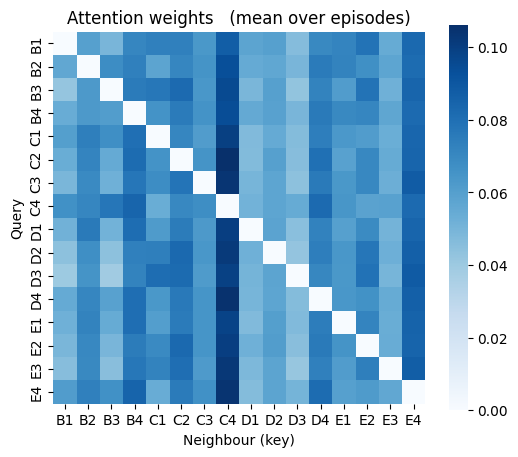

per-row σ  min: 0.019156273   max: 0.023038756


In [42]:
last_A = A[-1]         # (16,16)

sns.heatmap(last_A, vmax=last_A.max(), vmin=0,
            xticklabels=AGENTS, yticklabels=AGENTS,
            cmap="Blues", square=True)
plt.title("Attention weights   (mean over episodes)")
plt.ylabel("Query"); plt.xlabel("Neighbour (key)")
plt.show()

row_std = A[-1].std(axis=1)
print("per-row σ  min:", row_std.min(), "  max:", row_std.max())

In [43]:
k = 3
rows = []
for i,recv in enumerate(AGENTS):
    idx = np.argsort(last_A[i])[::-1][:k]
    rows.append({"Agent":recv,
                 "Top-k": ", ".join([AGENTS[j] for j in idx]),
                 "Weights": ", ".join([f"{last_A[i,j]:.2f}" for j in idx])})
pd.DataFrame(rows)


,Agent,Top-k,Weights
0,B1,"C4, E4, E2","0.09, 0.08, 0.08"
1,B2,"C4, E4, D4","0.09, 0.08, 0.08"
2,B3,"C4, E4, C2","0.10, 0.08, 0.08"
3,B4,"C4, E4, D4","0.09, 0.08, 0.08"
4,C1,"C4, E4, B4","0.10, 0.08, 0.08"
5,C2,"C4, E4, B4","0.11, 0.08, 0.08"
6,C3,"C4, E4, C2","0.10, 0.09, 0.08"
7,C4,"B4, D4, E4","0.08, 0.08, 0.08"
8,D1,"C4, E4, B4","0.10, 0.08, 0.08"
9,D2,"C4, E4, C2","0.10, 0.09, 0.08"


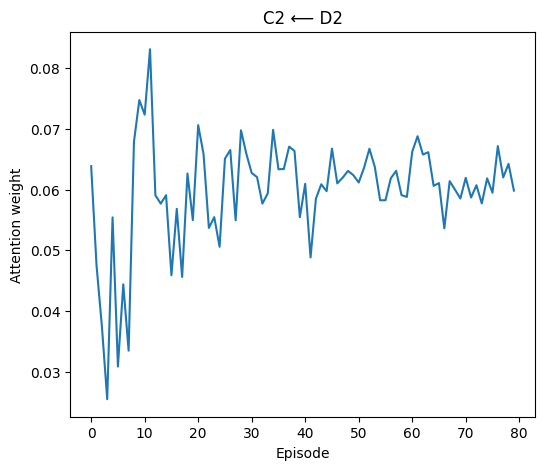

In [44]:
pair = ("C2","D2")        # receiver, neighbour
i, j = AGENTS.index(pair[0]), AGENTS.index(pair[1])

plt.plot(A[:, i, j])
plt.xlabel("Episode"); plt.ylabel("Attention weight")
plt.title(f"{pair[0]} ⟵ {pair[1]}")
plt.show()


In [45]:
def grid_heat(Amean, idx, ax=None, cmap="Blues"):
    """
    Amean : ndarray (16,16)
    idx   : int                
    """

    if ax is None:
        ax = plt.gca()

    # 1-D → 4×4 (column-major) → transpose → flip rows
    mat = Amean[idx].reshape(4, 4).T[::-1]      #   ←★ ONLY 1-LINE CHANGE

    sns.heatmap(mat,
                annot=True, fmt=".02f",
                cmap=cmap, square=True, cbar=False,
                xticklabels=["0","1","2","3"],
                yticklabels=["0","1","2","3"][::-1],
                ax=ax)
    ax.set_title(f"Agent {AGENTS[idx]}")
    ax.set_xlabel("col →")
    ax.set_ylabel("row ↑")



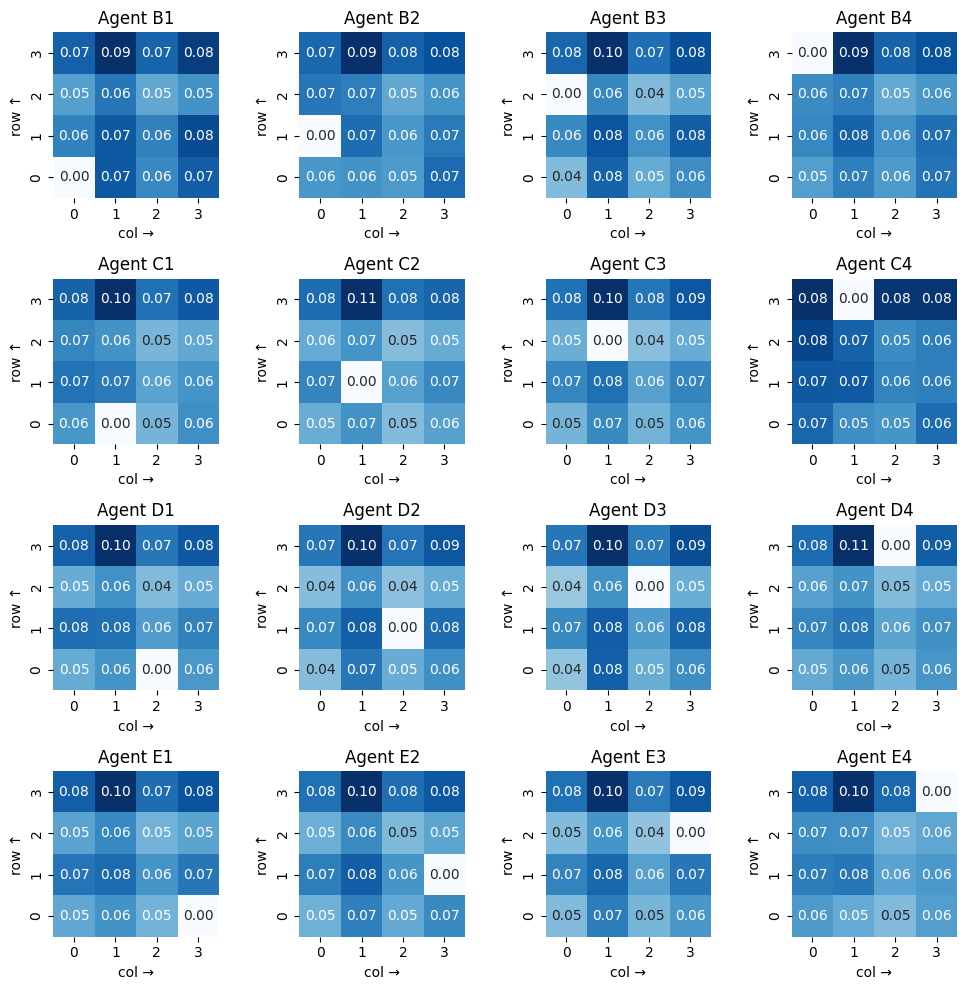

In [46]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
for k,ax in enumerate(axes.ravel()):
    grid_heat(last_A, k, ax=ax)
plt.tight_layout(); plt.show()


80


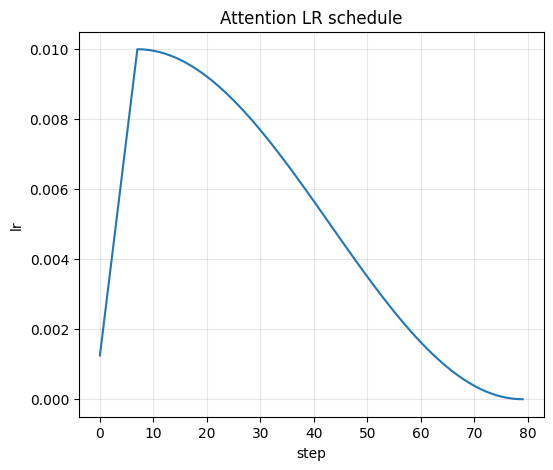

In [47]:
lrs=np.load("ckpt/block_normal/Ours_Attention/42_attn_lr_history.npy")
plt.plot(lrs)
plt.title("Attention LR schedule")
plt.xlabel("step"); plt.ylabel("lr")
plt.grid(alpha=.3)
print(len(lrs))